# Sarcasm Detector (Logistic Regression, LSTM, BERT)

### Import necessary libraries

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import joblib
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from transformers import BertTokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_tuner import RandomSearch
import json
from transformers import TFBertForSequenceClassification
from keras_tuner import HyperModel
from sklearn.preprocessing import StandardScaler
import string
from textblob import TextBlob

### Loading the dataset

In [121]:
gen_df=pd.read_csv('data/GEN-sarc-notsarc.csv')
hyp_df=pd.read_csv('data/HYP-sarc-notsarc.csv')
rhe_df=pd.read_csv('data/RQ-sarc-notsarc.csv')

In [122]:
gen_df.head()

,class,id,text
0,notsarc,1,"If that's true, then Freedom of Speech is doom..."
1,notsarc,2,Neener neener - is it time to go in from the p...
2,notsarc,3,"Just like the plastic gun fear, the armour pie..."
3,notsarc,4,So geology is a religion because we weren't he...
4,notsarc,5,Well done Monty. Mark that up as your first ev...


In [123]:
gen_df['Type']='GEN'
hyp_df['Type']='HYP'
rhe_df['Type']='RQ'

In [124]:
df = pd.concat([gen_df, hyp_df, rhe_df], ignore_index=True)

### Cleaning the dataset

In [125]:
# Clean text - removing special characters, numbers and coverting text to lower case
def clean_text(text):
    #text = re.sub(r'\d+', '', text)   
    #text = text.lower()  
    return text

In [126]:
# Preprocessing
df.isnull().sum()
df.dropna(inplace=True)
df['text'] = df['text'].apply(clean_text)

# Encode the class labels ('sarc' = 1, 'notsarc' = 0)
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['class'], test_size=0.2, random_state=42)

### EDA

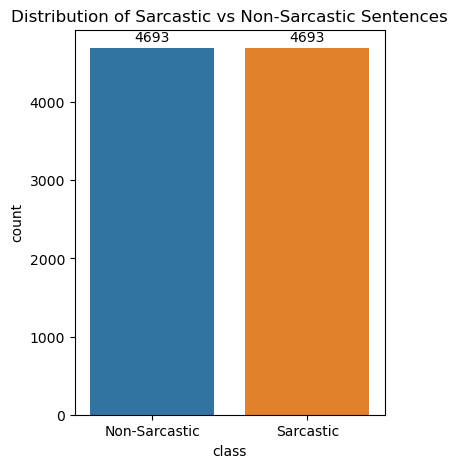

In [127]:
# Figuring out the distribution of sarcastic and non-sarcastic samples in the dataset
plt.figure(figsize=(4, 5))
ax = sns.countplot(x='class', data=df)
plt.title("Distribution of Sarcastic vs Non-Sarcastic Sentences")
plt.xticks([0, 1], ['Non-Sarcastic', 'Sarcastic'])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

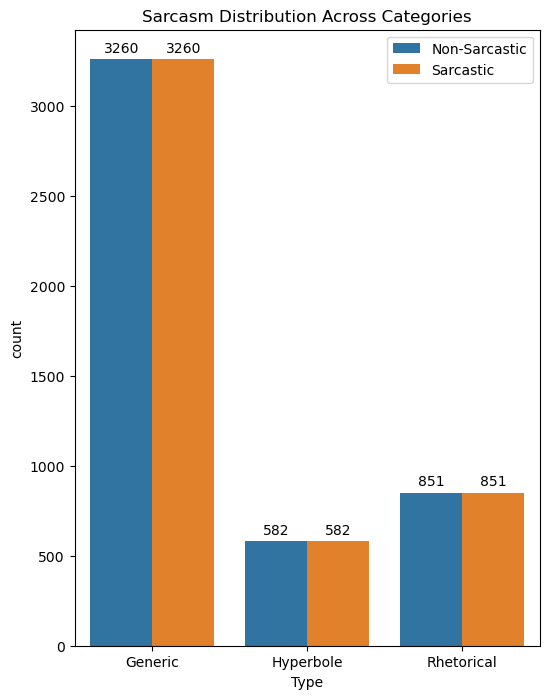

In [128]:
# Figuring out the distribution of sarcastic and non-sarcastic samples in the dataset
plt.figure(figsize=(6, 8))
ax = sns.countplot(x='Type',hue='class', data=df)
plt.title("Sarcasm Distribution Across Categories")
plt.xticks([0, 1, 2], ['Generic', 'Hyperbole', 'Rhetorical'])
plt.legend(['Non-Sarcastic', 'Sarcastic'])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

In [129]:
# Add a new column for sentence length (no of words)
df['sentence_length'] = df['text'].apply(lambda x: len(x.split()))

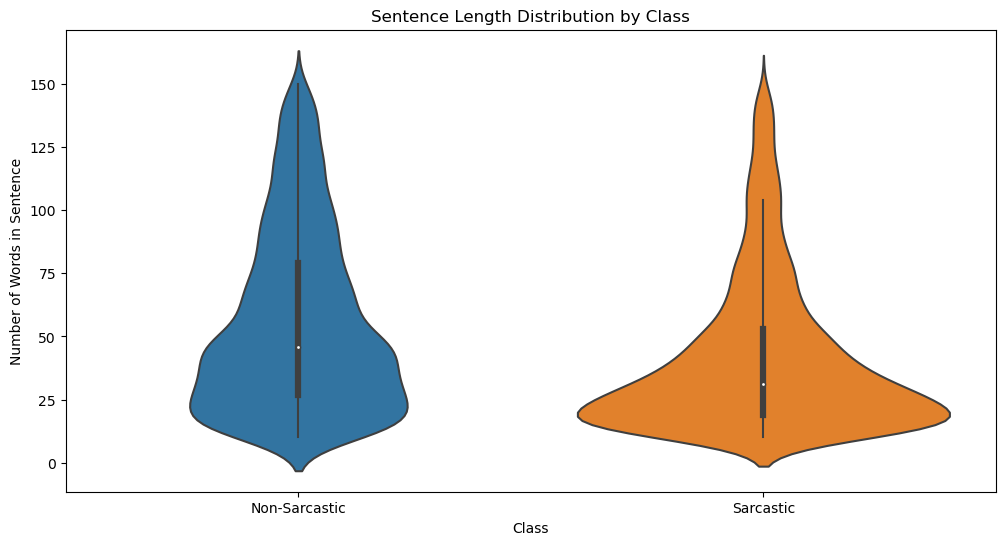

In [130]:
#Violin plot for sentence analysis
plt.figure(figsize=(12,6))
sns.violinplot(x='class', y='sentence_length', data=df)
plt.title('Sentence Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Number of Words in Sentence')
plt.xticks([0, 1], ['Non-Sarcastic', 'Sarcastic'])
plt.show()

In [131]:
# Define a custom stopword list by adding single-letter words
custom_stopwords = set(STOPWORDS)

# Separate sarcastic and non-sarcastic text for word cloud
sarc_text = ' '.join(df[df['class'] == 1]['text'].tolist())  # Assuming 'sarc' is sarcastic
notsarc_text = ' '.join(df[df['class'] == 0]['text'].tolist())  # Assuming 'notsarc' is non-sarcastic
sarc_text=sarc_text.split(' ')
notsarc_text=notsarc_text.split(' ')
sarc_text=[i for i in sarc_text if len(i)>1]
notsarc_text=[i for i in notsarc_text if len(i)>1]
sarc_text=' '.join(sarc_text)
notsarc_text=' '.join(notsarc_text)

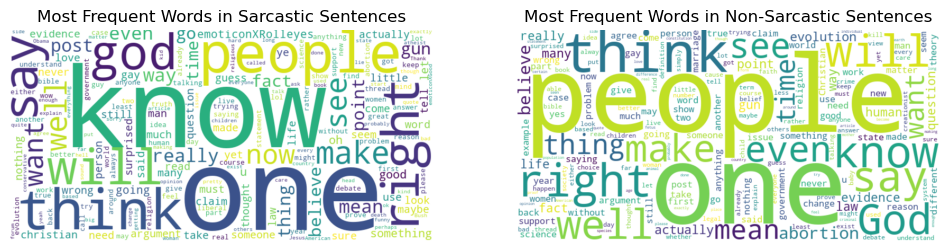

In [132]:
# Generate word clouds
plt.figure(figsize=(12, 6))

# Word cloud for sarcastic sentences
plt.subplot(1, 2, 1)
wordcloud_sarc = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(sarc_text)
plt.imshow(wordcloud_sarc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Sarcastic Sentences')

# Word cloud for non-sarcastic sentences
plt.subplot(1, 2, 2)
wordcloud_notsarc = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(notsarc_text)
plt.imshow(wordcloud_notsarc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Non-Sarcastic Sentences')

plt.show()

In [133]:
# Define a function to plot top N-grams for a specific class
def plot_top_ngrams_for_class(df, class_label, ngram_range=(2, 2), top_n=10):
    text_data = df[df['class'] == class_label]['text']
    vectorizer = CountVectorizer(ngram_range=ngram_range).fit(text_data)
    ngrams = vectorizer.transform(text_data)
    ngrams_sum = ngrams.sum(axis=0)
    ngram_counts = [(word, ngrams_sum[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    ngram_counts = sorted(ngram_counts, key=lambda x: x[1], reverse=True)[:top_n]
    ngrams_df = pd.DataFrame(ngram_counts, columns=['Ngram', 'Frequency'])
    
    return ngrams_df

# Function to plot both sarcastic and non-sarcastic N-grams side by side
def plot_ngrams_for_both_classes(df, ngram_range=(2, 2), top_n=10):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    ngrams_sarc = plot_top_ngrams_for_class(df, class_label=1, ngram_range=ngram_range, top_n=top_n)
    sns.barplot(x='Frequency', y='Ngram', data=ngrams_sarc)
    plt.title(f"Top {top_n} {'-'.join(map(str, ngram_range))}-grams in Sarcastic Sentences")
    plt.subplot(1, 2, 2)
    ngrams_notsarc = plot_top_ngrams_for_class(df, class_label=0, ngram_range=ngram_range, top_n=top_n)
    sns.barplot(x='Frequency', y='Ngram', data=ngrams_notsarc)
    plt.title(f"Top {top_n} {'-'.join(map(str, ngram_range))}-grams in Non-Sarcastic Sentences")
    plt.tight_layout()
    plt.show()

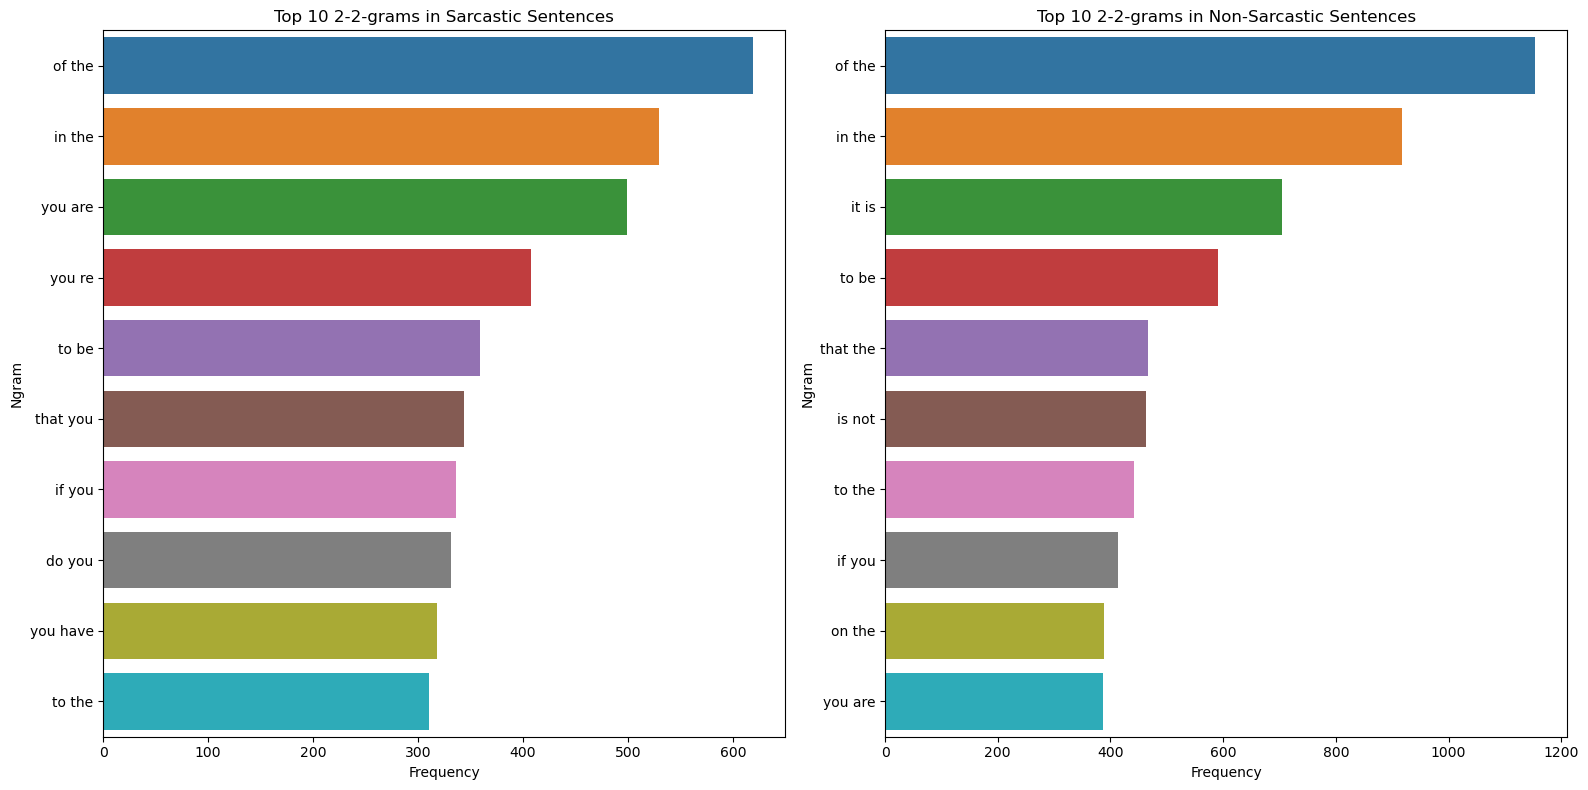

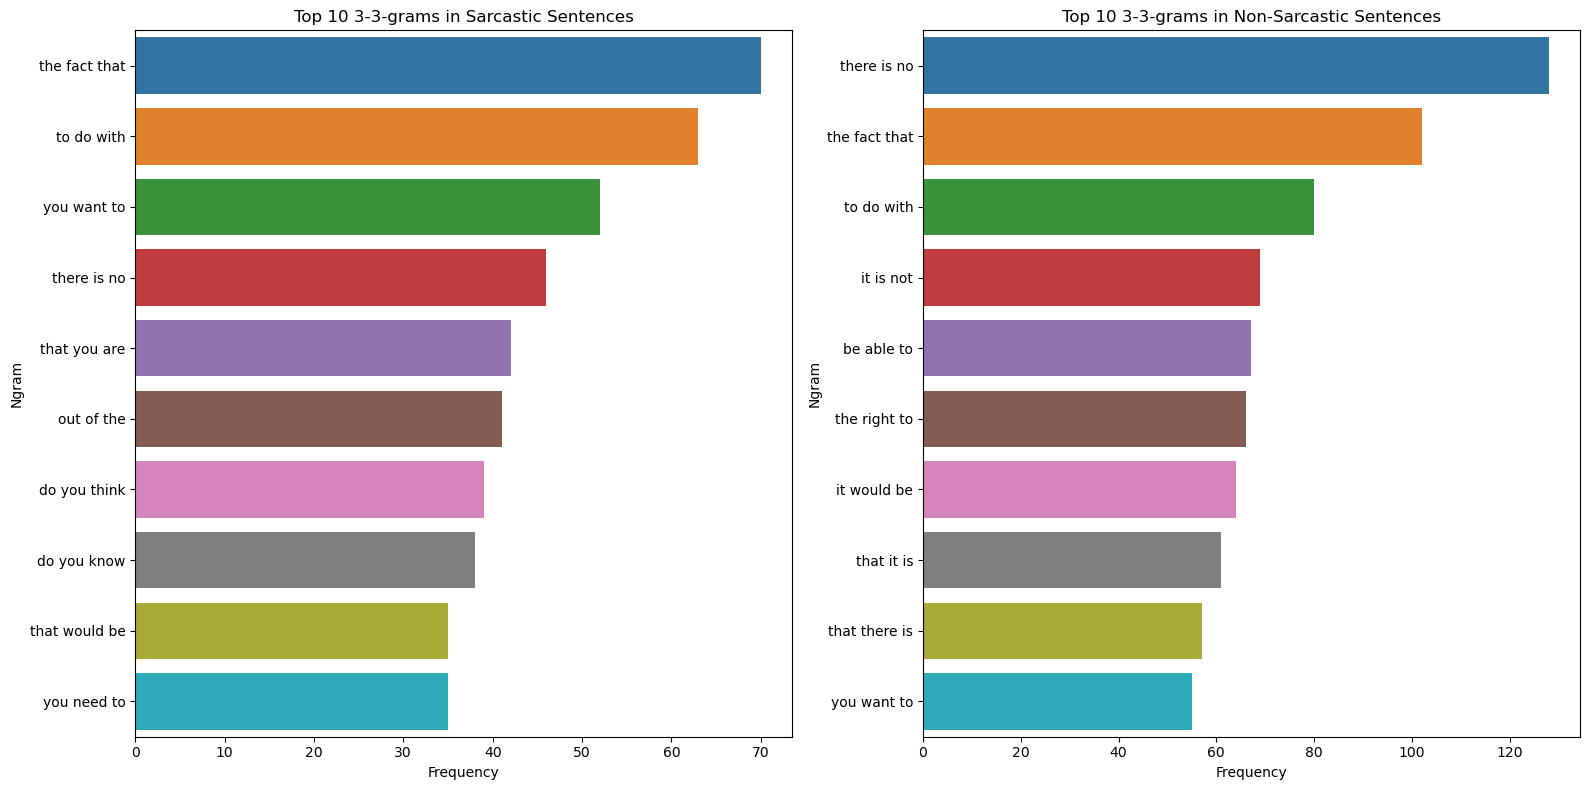

In [134]:
# Plot bigrams for both sarcastic and non-sarcastic sentences
plot_ngrams_for_both_classes(df, ngram_range=(2, 2), top_n=10)

# Plot trigrams for both sarcastic and non-sarcastic sentences
plot_ngrams_for_both_classes(df, ngram_range=(3, 3), top_n=10)

In [135]:
# Function to count the punctuation in test
def count_punctuation(text):
    return sum([1 for char in text if char in string.punctuation])

df['num_punctuation'] = df['text'].apply(count_punctuation)

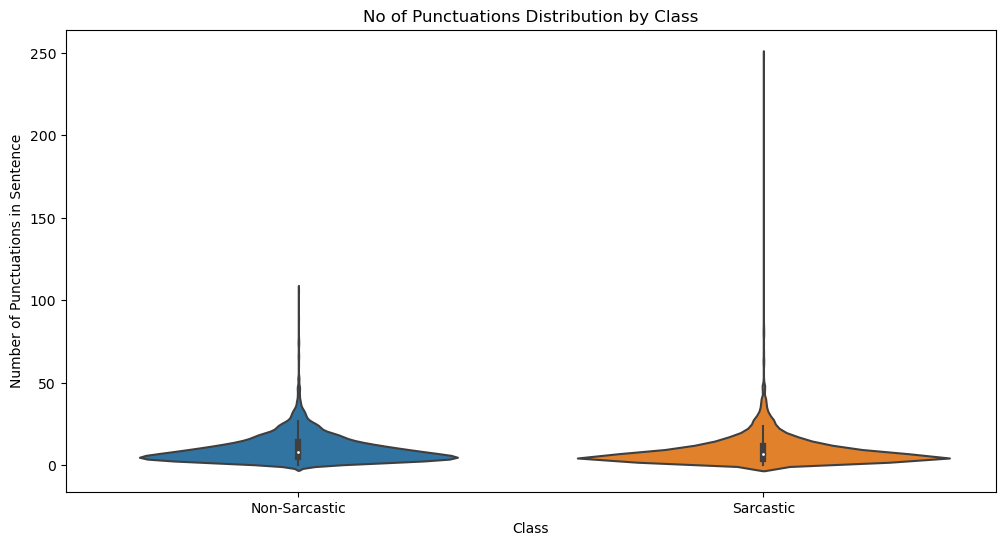

In [136]:
# Violin plot for number of punct in sentence analysis
plt.figure(figsize=(12,6))
sns.violinplot(x='class', y='num_punctuation', data=df)
plt.title('No of Punctuations Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Number of Punctuations in Sentence')
plt.xticks([0, 1], ['Non-Sarcastic', 'Sarcastic'])
plt.show()

In [137]:
# Function to count exclamation marks
def count_exclamation_marks(text):
    return text.count('!')

df['num_exclamations'] = df['text'].apply(count_exclamation_marks)

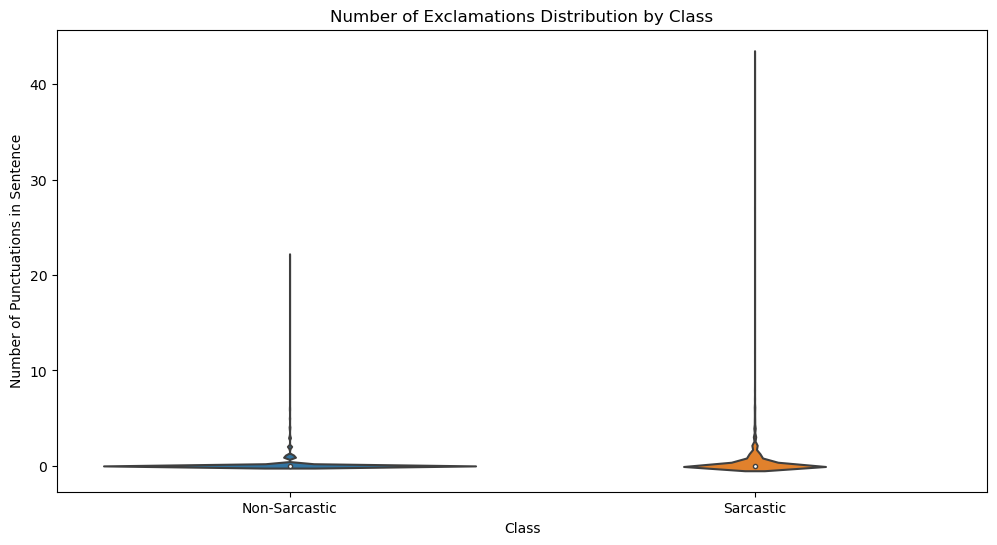

In [138]:
#Violin plot for number of exclamations in sentence analysis
plt.figure(figsize=(12,6))
sns.violinplot(x='class', y='num_exclamations', data=df)
plt.title('Number of Exclamations Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Number of Punctuations in Sentence')
plt.xticks([0, 1], ['Non-Sarcastic', 'Sarcastic'])
plt.show()

In [139]:
# Check if a positive sentiment word is followed by a negative context or vice-versa
def polarity_flip(text):
    blob = TextBlob(text)
    sentiment_list = [sentence.sentiment.polarity for sentence in blob.sentences]
    flip = any((x > 0 and y < 0) or (x < 0 and y > 0) for x, y in zip(sentiment_list[:-1], sentiment_list[1:]))
    return 1 if flip else 0
df['polarity_flip'] = df['text'].apply(polarity_flip)

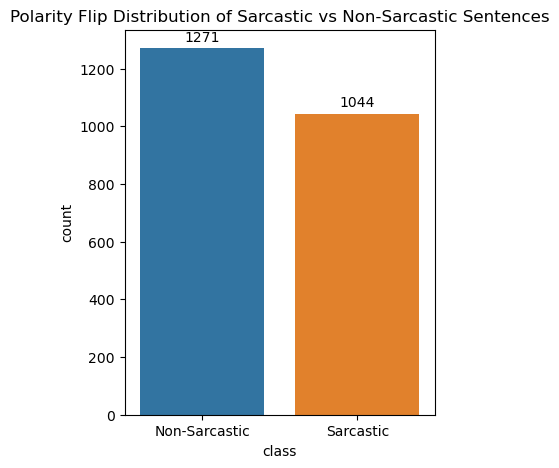

In [140]:
#Polarity flip viz
df_polarityflip=df[df['polarity_flip']==1]
# Figuring out the distribution of sarcastic and non-sarcastic samples in the dataset that have a polarity flip
plt.figure(figsize=(4, 5))
ax = sns.countplot(x='class', data=df_polarityflip)
plt.title("Polarity Flip Distribution of Sarcastic vs Non-Sarcastic Sentences")
plt.xticks([0, 1], ['Non-Sarcastic', 'Sarcastic'])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

In [141]:
# Check if the sentence contains both positive and negative sentiments
def polarity_shift(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

df['polarity_shift'] = df['text'].apply(polarity_shift)

In [142]:
df['polarity_shift']=df['polarity_shift'].astype('category')

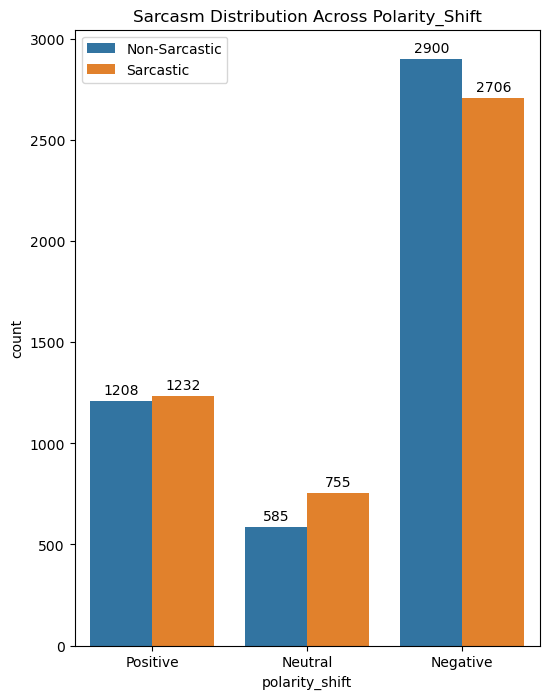

In [143]:
# Figuring out the distribution of sarcastic and non-sarcastic samples in the dataset
plt.figure(figsize=(6, 8))
ax = sns.countplot(x='polarity_shift',hue='class', data=df)
plt.title("Sarcasm Distribution Across Polarity_Shift")
plt.xticks([0, 1, 2], ['Positive', 'Neutral', 'Negative'])
plt.legend(['Non-Sarcastic', 'Sarcastic'])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

In [144]:
# Label for Type (General, Hyperbole, or Rhetorical Question)
df['Type_label'] = df['Type'].map({'GEN': 0, 'HYP': 1, 'RQ': 2})

In [145]:
# Positive Word + Hyperbole Interaction Feature
def positive_words_count(text):
    blob = TextBlob(text)
    return sum([1 for word in blob.words if TextBlob(word).sentiment.polarity > 0])

df['positive_words_count'] = df['text'].apply(positive_words_count)

df['positive_hyperbole_interaction'] = df.apply(
    lambda x: x['positive_words_count'] if x['Type'] == 'Hyperbole' else 0, axis=1
)

# Negative Word + Rhetorical Question Interaction Feature
def negative_words_count(text):
    blob = TextBlob(text)
    return sum([1 for word in blob.words if TextBlob(word).sentiment.polarity < 0])

df['negative_words_count'] = df['text'].apply(negative_words_count)

df['negative_rhetorical_interaction'] = df.apply(
    lambda x: x['negative_words_count'] if x['Type'] == 'Rhetorical Question' else 0, axis=1
)

In [146]:
# Final df with features
df.head()

,class,id,text,Type,sentence_length,num_punctuation,num_exclamations,polarity_flip,polarity_shift,Type_label,positive_words_count,positive_hyperbole_interaction,negative_words_count,negative_rhetorical_interaction
0,0,1,"If that's true, then Freedom of Speech is doom...",GEN,30,7,0,0,Positive,0,1,0,0,0
1,0,2,Neener neener - is it time to go in from the p...,GEN,13,2,0,0,Neutral,0,0,0,0,0
2,0,3,"Just like the plastic gun fear, the armour pie...",GEN,17,2,0,0,Neutral,0,0,0,0,0
3,0,4,So geology is a religion because we weren't he...,GEN,14,2,0,0,Neutral,0,0,0,0,0
4,0,5,Well done Monty. Mark that up as your first ev...,GEN,16,3,0,0,Positive,0,3,0,0,0


In [147]:
# Label for Type (General, Hyperbole, or Rhetorical Question)
df['polarity_shift_label'] = df['polarity_shift'].map({'Positive': 0, 'Neutral': 1, 'Negative': 2})

## Logistic Regression with GridCV

In [148]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3), stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [149]:
# Logistic Regression with class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
model = LogisticRegression(class_weight=class_weight_dict, max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight={0: 0.9997336884154461, 1: 1.0002664535038637},
                   max_iter=1000)

Accuracy: 0.7188498402555911

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.75      0.73       938
           1       0.73      0.69      0.71       940

    accuracy                           0.72      1878
   macro avg       0.72      0.72      0.72      1878
weighted avg       0.72      0.72      0.72      1878



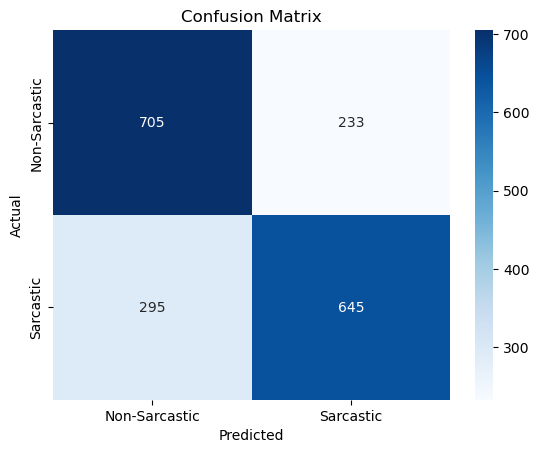

In [150]:
#Predictions and Evaluation 
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Sarcastic', 'Sarcastic'], yticklabels=['Non-Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [151]:
#Grid Search for hyperparamter tuning

#Define the hyperparameters grid
param_grid = {
    'C': [0.01,0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': ['balanced', None]
}


grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_tfidf, y_train)

best_params = grid_search.best_params_
print("Best Parameters: ", best_params)
best_log_reg=grid_search.best_estimator_
best_model = LogisticRegression(**best_params)
best_model.fit(X_train_tfidf, y_train)

y_pred_best = best_model.predict(X_test_tfidf)
print("Accuracy with tuned model:", accuracy_score(y_test, y_pred_best))

Best Parameters:  {'C': 1, 'class_weight': 'balanced', 'solver': 'liblinear'}
Accuracy with tuned model: 0.7188498402555911


In [152]:
#Saving Log Reg Model
joblib.dump(best_log_reg, 'models/best_logistic_regression_model.pkl')
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')
print("Best Logistic Regression model and vectorizer saved successfully!")

Best Logistic Regression model and vectorizer saved successfully!


## LSTM with Random Tuner

In [39]:
MAX_VOCAB_SIZE = 100000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

In [40]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [41]:
# LSTM model
def build_lstm_model(hp):
    model = Sequential()

    # Embedding
    model.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    
    # LSTM layer
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=False)))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Output
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [42]:
# Keras Tuner RandomSearch
tuner = RandomSearch(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=5,  
    executions_per_trial=2,  
    directory='lstm_hyperparam_tuning',
    project_name='sarcasm_detection_lstm'
)

tuner.search(X_train_padded, y_train, epochs=5, validation_data=(X_test_padded, y_test))

best_lstm_model = tuner.get_best_models(num_models=1)[0]

best_lstm_model.evaluate(X_test_padded, y_test)

Trial 5 Complete [00h 02m 44s]
val_accuracy: 0.7398828566074371

Best val_accuracy So Far: 0.7425452768802643
Total elapsed time: 00h 16m 51s
59/59 [==============================] - 2s 17ms/step - loss: 0.5201 - accuracy: 0.7444


[0.5200909376144409, 0.7444089651107788]

In [43]:
# Save the best LSTM model
best_lstm_model.save('models/best_lstm_model.keras')
joblib.dump(tokenizer, 'models/tokenizer.pkl')

print("Best LSTM model and tokenizer saved successfully!")

Best LSTM model and tokenizer saved successfully!


### Pre-trained BERT

In [46]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define max sequence length for padding and ultimately less computation
MAX_LEN = 128

In [47]:
# Tokenize and encode text data
def tokenize_text(text_list):
    return tokenizer(
        text_list, 
        padding=True, 
        truncation=True, 
        max_length=MAX_LEN, 
        return_tensors="tf"
    )

In [48]:
# Tokenize train and test data
train_encodings = tokenize_text(X_train.tolist())
test_encodings = tokenize_text(X_test.tolist())

# Labels to tensors
train_labels = tf.convert_to_tensor(y_train.tolist())
test_labels = tf.convert_to_tensor(y_test.tolist())

In [49]:
# Load pre-trained BERT model with a classification head
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train 
history = model.fit(
    train_encodings['input_ids'], train_labels,
    validation_data=(test_encodings['input_ids'], test_labels),
    epochs=3,
    batch_size=16
)

# Evaluate
model.evaluate(test_encodings['input_ids'], test_labels)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
 57/470 [==>...........................] - ETA: 40:51 - loss: 0.6960 - accuracy: 0.5077

KeyboardInterrupt: 

### ~~Hyperparameter Tuning Using Random Tuner~~  (Computationally heavy) 

In [ ]:
class BertHyperModel(HyperModel):
    def build(self, hp):
        # Load pre-trained BERT model with a classification head
        model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

        # Define the optimizer with tuneable learning rate
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [2e-5, 3e-5, 5e-5]))

        # Compile the model
        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        
        return model


In [ ]:
# Initialize the tuner with RandomSearch
tuner = RandomSearch(
    BertHyperModel(),
    objective='val_accuracy',
    max_trials=3,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train per combination
    directory='bert_hyperparam_tuning',
    project_name='sarcasm_detection'
)

# Start searching for the best hyperparameters
tuner.search(train_encodings['input_ids'], train_labels, 
             validation_data=(test_encodings['input_ids'], test_labels), 
             epochs=3, batch_size=16)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
# Save the fine-tuned model and the tokenizer
model.save_pretrained('best_bert_model')
tokenizer.save_pretrained('bert_tokenizer')

print("Best BERT model and tokenizer saved successfully!")

### Logistic Regression with Feature Selection and GridCV

In [110]:
X_text = df['text']  # Text column to be vectorized
X_other = df.drop(columns=['text', 'class','Type','polarity_shift'])  # All other features except text and class
y = df['class']  # Target variable

# Train-test split on both text and other features
X_train_text, X_test_text, X_train_other, X_test_other, y_train_feature, y_test_feature = train_test_split(X_text, X_other, y, test_size=0.2, random_state=42, stratify=y)

In [111]:
X_train_other

,id,sentence_length,num_punctuation,num_exclamations,polarity_flip,Type_label,positive_words_count,positive_hyperbole_interaction,negative_words_count,negative_rhetorical_interaction,polarity_shift_label
7934,251,51,10,0,0,2,1,0,1,0,0
5402,5403,16,6,0,0,0,0,0,0,0,1
7069,550,45,7,0,0,1,1,0,1,0,2
1656,1657,20,2,0,0,0,2,0,0,0,0
6726,207,39,12,0,0,1,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8846,1163,53,10,2,0,2,1,0,0,0,0
7628,1109,13,4,0,0,1,1,0,0,0,0
2796,2797,51,21,1,1,0,4,0,2,0,0
2222,2223,75,6,0,0,0,1,0,4,0,2


In [112]:
# TF-IDF Vectorization for text data
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# Standardize Data
scaler = StandardScaler()
X_train_other_scaled = scaler.fit_transform(X_train_other)
X_test_other_scaled = scaler.transform(X_test_other)

# Concatenate TF-IDF features with other features
# TF-IDF sparse to dense
X_train_combined = np.hstack((X_train_tfidf.toarray(), X_train_other_scaled))
X_test_combined = np.hstack((X_test_tfidf.toarray(), X_test_other_scaled))
X_train_combined=np.nan_to_num(X_train_combined, nan=0)
X_test_combined=np.nan_to_num(X_test_combined,nan=0)

print("X_train_combined shape:", X_train_combined.shape)
print("X_test_combined shape:", X_test_combined.shape)
print("y_train shape:", y_train_feature.shape)
print("y_test shape:", y_test_feature.shape)

X_train_combined shape: (7508, 10011)
X_test_combined shape: (1878, 10011)
y_train shape: (7508,)
y_test shape: (1878,)


In [113]:
# L1 Regularization for feature selection and training
model = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=10000)
model.fit(X_train_combined, y_train_feature)

LogisticRegression(class_weight='balanced', max_iter=10000, penalty='l1',
                   solver='liblinear')

In [114]:
# Get the coefficients of the features
coefficients = model.coef_[0]

# Features with non-zero coefficients
selected_features = [i for i in range(len(coefficients)) if coefficients[i] != 0]

# Select the important features from both train and test data
X_train_selected = X_train_combined[:, selected_features]
X_test_selected = X_test_combined[:, selected_features]

Accuracy: 0.8029818956336529

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80       939
           1       0.79      0.82      0.81       939

    accuracy                           0.80      1878
   macro avg       0.80      0.80      0.80      1878
weighted avg       0.80      0.80      0.80      1878



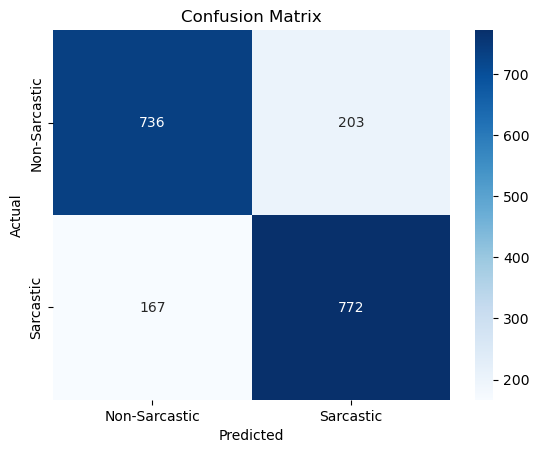

In [115]:
# Logistic Regression after feature selection
model.fit(X_train_selected, y_train_feature)
y_pred = model.predict(X_test_selected)

# Evaluate accuracy and print classification report
print("Accuracy:", accuracy_score(y_test_feature, y_pred))
print("\nClassification Report:\n", classification_report(y_test_feature, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_feature, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Sarcastic', 'Sarcastic'], yticklabels=['Non-Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [116]:
# Define the hyperparameters grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': ['balanced', None]
}

# Create a Logistic Regression model instance
model = LogisticRegression(max_iter=1000)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search on the combined training data
grid_search.fit(X_train_combined, y_train_feature)

# Get the best parameters and best model
best_params = grid_search.best_params_
print("Best Parameters: ", best_params)

Best Parameters:  {'C': 1, 'class_weight': 'balanced', 'solver': 'lbfgs'}


Best Logistic Regression model from GridSearchCV saved successfully!
Accuracy with best model: 0.8152289669861554

Classification Report for best model:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81       939
           1       0.79      0.85      0.82       939

    accuracy                           0.82      1878
   macro avg       0.82      0.82      0.82      1878
weighted avg       0.82      0.82      0.82      1878



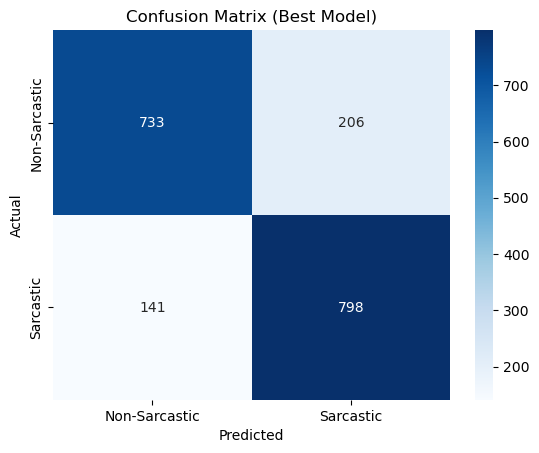

In [117]:
# Get the best estimator (model with best parameters)
best_model = grid_search.best_estimator_

# Train the best model on the selected features
best_model.fit(X_train_combined, y_train_feature)

# Save the best model
joblib.dump(best_model, 'models/best_logistic_regression_gridsearch_l1.pkl')
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
print("Best Logistic Regression model from GridSearchCV saved successfully!")

# Evaluate the best model
y_pred_best = best_model.predict(X_test_combined)

# Evaluate accuracy and print classification report for best model
print("Accuracy with best model:", accuracy_score(y_test_feature, y_pred_best))
print("\nClassification Report for best model:\n", classification_report(y_test_feature, y_pred_best))

# Confusion Matrix for best model
cm = confusion_matrix(y_test_feature, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Sarcastic', 'Sarcastic'], yticklabels=['Non-Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Model)')
plt.show()


### Saving the performance metric of each model

In [53]:
# Function to calculate metrics and save to a JSON file
def save_metrics(model_name, y_true, y_pred):
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred).tolist()  # convert to list for saving in JSON format

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

    # Saving metric as JSON
    with open(f'metrics/{model_name}_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=4)
    
    print(f"Metrics for {model_name} saved successfully!")


In [153]:
# Logistic Regression Predictions
y_pred_log_reg = best_log_reg.predict(X_test_tfidf)
save_metrics('logistic_regression', y_test, y_pred_log_reg)

Metrics for logistic_regression saved successfully!


In [118]:
# Logistic Regression Feature Selection using L1 Predictions
y_pred_log_reg_feature=best_model.predict(X_test_combined)
save_metrics('logistic_regression_feature', y_test_feature, y_pred_log_reg_feature)

Metrics for logistic_regression_feature saved successfully!


In [56]:
# LSTM Predictions
y_pred_lstm = (best_lstm_model.predict(X_test_padded) > 0.5).astype(int).flatten()
save_metrics('lstm', y_test, y_pred_lstm)

59/59 [==============================] - 2s 15ms/step
Metrics for lstm saved successfully!


In [ ]:
# BERT Predictions
y_pred_bert_logits = model.predict(test_encodings['input_ids'])
y_pred_bert = tf.argmax(tf.nn.softmax(y_pred_bert_logits.logits, axis=1), axis=1).numpy()
save_metrics('bert', y_test, y_pred_bert)

In [154]:
# Function to read the saved metrics from a JSON file
def load_metrics(model_name):
    with open(f'metrics/{model_name}_metrics.json', 'r') as f:
        metrics = json.load(f)
    return metrics

# Example usage
log_reg_metrics = load_metrics('logistic_regression')
lstm_metrics = load_metrics('lstm')
bert_metrics = load_metrics('bert')
log_reg_feature_metrics=load_metrics('logistic_regression_feature')

print("Logistic Regression Metrics:", log_reg_metrics)
print('Logistic Regression L1 Metrics',log_reg_feature_metrics)
print("LSTM Metrics:", lstm_metrics)
print("BERT Metrics:", bert_metrics)

Logistic Regression Metrics: {'accuracy': 0.7188498402555911, 'precision': 0.734624145785877, 'recall': 0.6861702127659575, 'f1_score': 0.7095709570957097, 'confusion_matrix': [[705, 233], [295, 645]]}
Logistic Regression L1 Metrics {'accuracy': 0.8152289669861554, 'precision': 0.7948207171314741, 'recall': 0.8498402555910544, 'f1_score': 0.8214101904271746, 'confusion_matrix': [[733, 206], [141, 798]]}
LSTM Metrics: {'accuracy': 0.744408945686901, 'precision': 0.7405857740585774, 'recall': 0.7531914893617021, 'f1_score': 0.7468354430379747, 'confusion_matrix': [[690, 248], [232, 708]]}
BERT Metrics: {'accuracy': 0.8067092651757188, 'precision': 0.8312284730195177, 'recall': 0.7702127659574468, 'f1_score': 0.7995582551076752, 'confusion_matrix': [[791, 147], [216, 724]]}
